Examples with gmr
-----------------

John Kitchin and Alexander Fabisch



## Examples with gmr



### Linear Gaussian Models for Regression



In this example, we use a MVN to approximate a linear function and a mixture of MVNs to approximate a nonlinear function. We estimate $p(x, y)$ first and then we compute the conditional distribution $p(y | x)$.



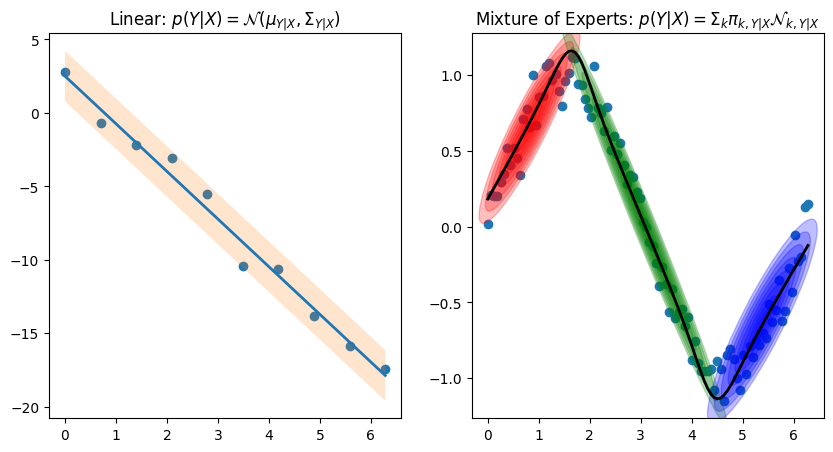

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses

random_state = check_random_state(0)

n_samples = 10
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = 1 - 3 * X[:, 0] + random_state.randn(n_samples)

mvn = MVN(random_state=0)
mvn.from_samples(X)

X_test = np.linspace(0, 2 * np.pi, 100)
mean, covariance = mvn.predict(np.array([0]), X_test[:, np.newaxis])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title(r"Linear: $p(Y | X) = \mathcal{N}(\mu_{Y|X}, \Sigma_{Y|X})$")
plt.scatter(X[:, 0], X[:, 1])
y = mean.ravel()
s = 1.96 * np.sqrt(covariance.ravel())  # interval covers 95% of the data
plt.fill_between(X_test, y - s, y + s, alpha=0.2)
plt.plot(X_test, y, lw=2)

n_samples = 100
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = np.sin(X[:, 0]) + random_state.randn(n_samples) * 0.1

gmm = GMM(n_components=3, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title(r"Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          r"\mathcal{N}_{k, Y|X}$")
plt.scatter(X[:, 0], X[:, 1])
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b"])
plt.plot(X_test, Y.ravel(), c="k", lw=2);

### Multimodal Regression



In multimodal regression we do not try to fit a function $f(x) = y$ but a probability distribution $p(y|x)$ with more than one peak in the probability density function.

The dataset that we use to illustrate multimodal regression by Gaussian mixture regression is from Section 5 of C. M. Bishop, "Mixture Density Networks", 1994, [https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf](https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf)



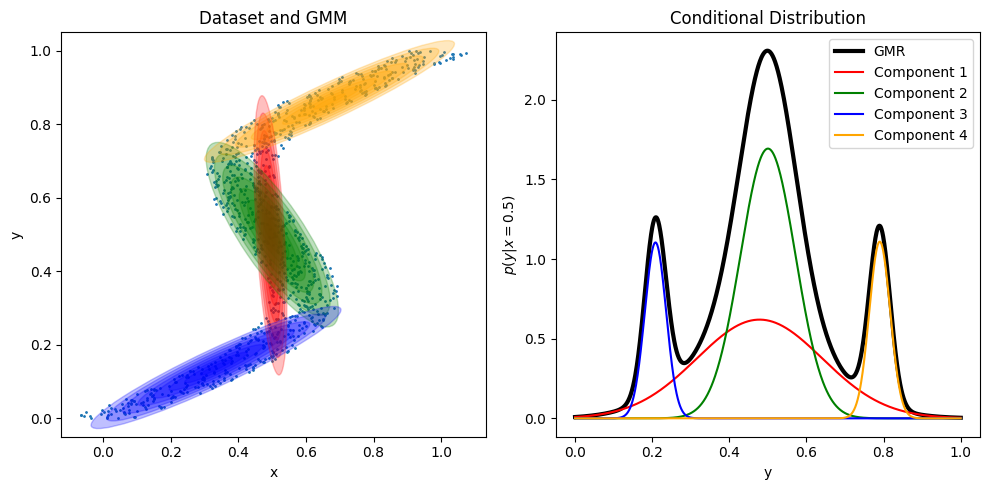

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gmr import GMM, plot_error_ellipses


def f(y, random_state):
    eps = random_state.rand(*y.shape) * 0.2 - 0.1
    return y + 0.3 * np.sin(2.0 * np.pi * y) + eps


y = np.linspace(0, 1, 1000)
random_state = np.random.RandomState(3)
x = f(y, random_state)

XY_train = np.column_stack((x, y))
gmm = GMM(n_components=4, random_state=random_state)
gmm.from_samples(XY_train)

plt.figure(figsize=(10, 5))

ax = plt.subplot(121)
ax.set_title("Dataset and GMM")
ax.scatter(x, y, s=1)
colors = ["r", "g", "b", "orange"]
plot_error_ellipses(ax, gmm, colors=colors)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = plt.subplot(122)
ax.set_title("Conditional Distribution")
Y = np.linspace(0, 1, 1000)
Y_test = Y[:, np.newaxis]
X_test = 0.5
conditional_gmm = gmm.condition([0], [X_test])
p_of_Y = conditional_gmm.to_probability_density(Y_test)
ax.plot(Y, p_of_Y, color="k", label="GMR", lw=3)
for component_idx in range(conditional_gmm.n_components):
    p_of_Y = (conditional_gmm.priors[component_idx]
              * conditional_gmm.extract_mvn(
                component_idx).to_probability_density(Y_test))
    ax.plot(Y, p_of_Y, color=colors[component_idx],
            label="Component %d" % (component_idx + 1))
ax.set_xlabel("y")
ax.set_ylabel("$p(y|x=%.1f)$" % X_test)
ax.legend(loc="best")

plt.tight_layout();

On the left side of the figure you see the training data and the fitted GMM indicated by ellipses corresponding to its components. On the right side you see the predicted probability density $p(y|x=0.5)$. There are three peaks that correspond to three different valid predictions. Each peak is represented by at least one of the Gaussians of the GMM.



### Learning Curve with scikit-learn



Here we use sklearn's learning curve to explore the impact of the training set size. The GaussianMixtureRegressor could also be used for model selection with sklearn.



[learning_curve] Training set sizes: [ 1376  4472  7568 10664 13760]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    1.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.3s finished


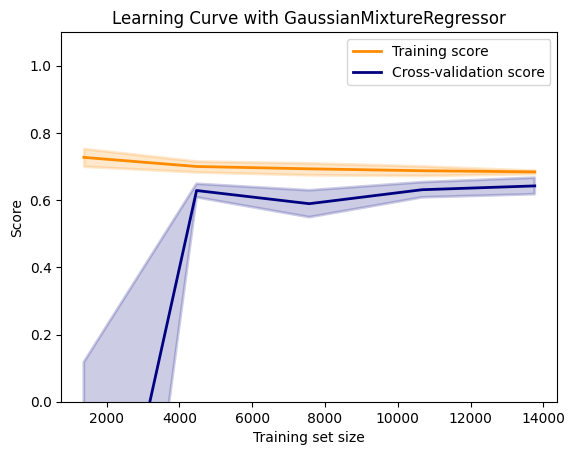

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from gmr.sklearn import GaussianMixtureRegressor
from sklearn.datasets import fetch_california_housing


X, y = fetch_california_housing(return_X_y=True)
random_state = np.random.RandomState(0)
train_sizes_abs, train_scores, test_scores = learning_curve(
    GaussianMixtureRegressor(n_components=3, random_state=random_state),
    X, y, cv=3, verbose=2, n_jobs=-1, random_state=random_state)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Learning Curve with GaussianMixtureRegressor")
plt.xlabel(r"Training set size")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(train_sizes_abs, train_scores_mean, label="Training score",
         color="darkorange", lw=lw)
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(train_sizes_abs, test_scores_mean, label="Cross-validation score",
         color="navy", lw=lw)
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best");

### Confidence Interval of a 1D Standard Normal Distribution



We plot the 0.6827 confidence interval of a standard normal distribution in one dimension. The confidence interval is marked by green lines and the region outside of the confidence interval is marked by red lines.



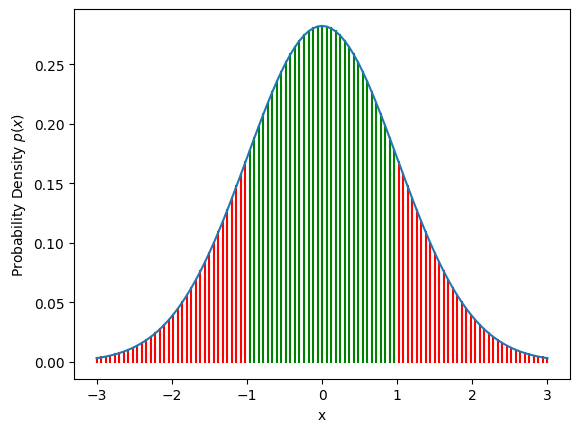

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from gmr import MVN


mvn = MVN(mean=[0.0], covariance=[[1.0]])
alpha = 0.6827
X = np.linspace(-3, 3, 101)[:, np.newaxis]
P = mvn.to_probability_density(X)

for x, p in zip(X, P):
    conf = mvn.is_in_confidence_region(x, alpha)
    color = "g" if conf else "r"
    plt.plot([x[0], x[0]], [0, p], color=color)

plt.plot(X.ravel(), P)

plt.xlabel("x")
plt.ylabel("Probability Density $p(x)$")
plt.show()

### Sample from Confidence Interval of a MVN



Sometimes we want to avoid sampling regions of low probability. We will see how this can be done in this example. We compare unconstrained sampling with sampling from the 95.45 % and 68.27 % confidence regions. In a one-dimensional Gaussian these would correspond to the 2-sigma and sigma intervals respectively.



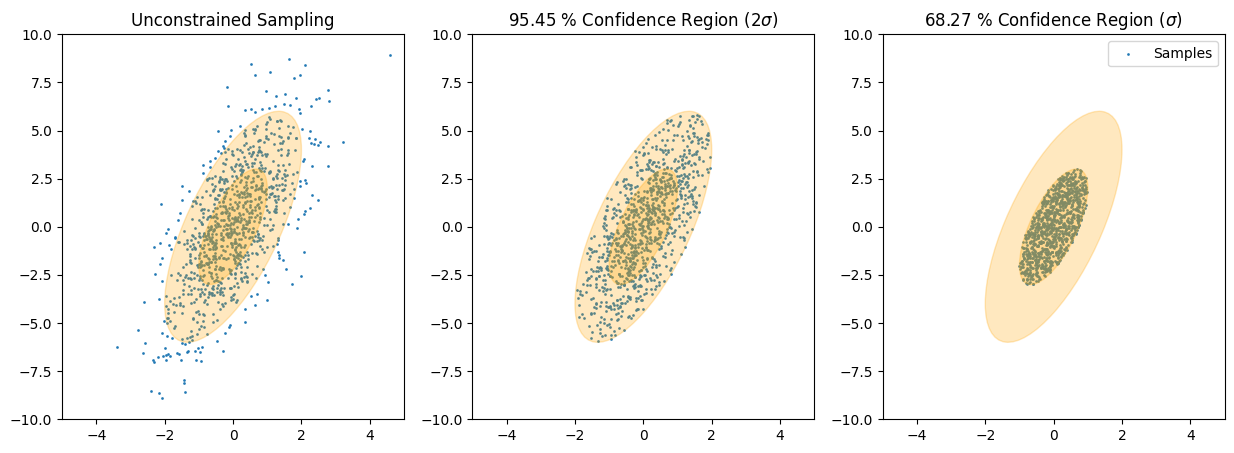

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from gmr import MVN, plot_error_ellipse


random_state = np.random.RandomState(100)
mvn = MVN(
    mean=np.array([0.0, 0.0]),
    covariance=np.array([[1.0, 2.0], [2.0, 9.0]]),
    random_state=random_state)

n_samples = 1000

plt.figure(figsize=(15, 5))

ax = plt.subplot(131)
ax.set_title("Unconstrained Sampling")
samples = mvn.sample(n_samples)
ax.scatter(samples[:, 0], samples[:, 1], alpha=0.9, s=1, label="Samples")
plot_error_ellipse(ax, mvn, factors=(1.0, 2.0), color="orange")
ax.set_xlim((-5, 5))
ax.set_ylim((-10, 10))

ax = plt.subplot(132)
ax.set_title(r"95.45 % Confidence Region ($2\sigma$)")
samples = mvn.sample_confidence_region(n_samples, 0.9545)
ax.scatter(samples[:, 0], samples[:, 1], alpha=0.9, s=1, label="Samples")
plot_error_ellipse(ax, mvn, factors=(1.0, 2.0), color="orange")
ax.set_xlim((-5, 5))
ax.set_ylim((-10, 10))

ax = plt.subplot(133)
ax.set_title(r"68.27 % Confidence Region ($\sigma$)")
samples = mvn.sample_confidence_region(n_samples, 0.6827)
ax.scatter(samples[:, 0], samples[:, 1], alpha=0.9, s=1, label="Samples")
plot_error_ellipse(ax, mvn, factors=(1.0, 2.0), color="orange")
ax.set_xlim((-5, 5))
ax.set_ylim((-10, 10))
ax.legend();

### Sample from Confidence Interval of a GMM



Sometimes we want to avoid sampling regions of low probability. We will see how this can be done in this example. We compare unconstrained sampling with sampling from the 95.45 % and 68.27 % confidence regions. In a one-dimensional Gaussian these would correspond to the 2-sigma and sigma intervals respectively.



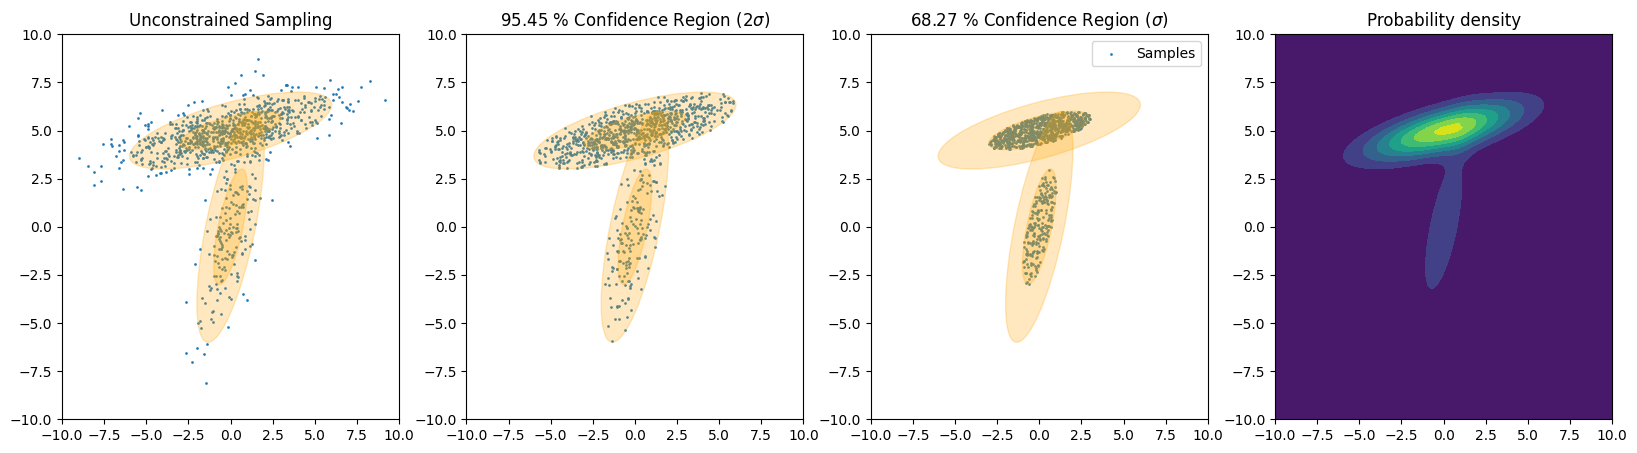

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from gmr import GMM, plot_error_ellipses


random_state = np.random.RandomState(100)
gmm = GMM(
    n_components=2,
    priors=np.array([0.2, 0.8]),
    means=np.array([[0.0, 0.0], [0.0, 5.0]]),
    covariances=np.array([[[1.0, 2.0], [2.0, 9.0]], [[9.0, 2.0], [2.0, 1.0]]]),
    random_state=random_state)

n_samples = 1000

plt.figure(figsize=(20, 5))

ax = plt.subplot(141)
ax.set_title("Unconstrained Sampling")
samples = gmm.sample(n_samples)
ax.scatter(samples[:, 0], samples[:, 1], alpha=0.9, s=1, label="Samples")
plot_error_ellipses(ax, gmm, factors=(1.0, 2.0), colors=["orange", "orange"])
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))

ax = plt.subplot(142)
ax.set_title(r"95.45 % Confidence Region ($2\sigma$)")
samples = gmm.sample_confidence_region(n_samples, 0.9545)
ax.scatter(samples[:, 0], samples[:, 1], alpha=0.9, s=1, label="Samples")
plot_error_ellipses(ax, gmm, factors=(1.0, 2.0), colors=["orange", "orange"])
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))

ax = plt.subplot(143)
ax.set_title(r"68.27 % Confidence Region ($\sigma$)")
samples = gmm.sample_confidence_region(n_samples, 0.6827)
ax.scatter(samples[:, 0], samples[:, 1], alpha=0.9, s=1, label="Samples")
plot_error_ellipses(ax, gmm, factors=(1.0, 2.0), colors=["orange", "orange"])
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.legend()

ax = plt.subplot(144)
ax.set_title(r"Probability density")
x, y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
X_test = np.vstack((x.ravel(), y.ravel())).T
p = gmm.to_probability_density(X_test)
p = p.reshape(*x.shape)
plt.contourf(x, y, p);

### Clustering Iris Dataset



The Iris dataset is a typical classification problem. We will cluster it with GMM and see whether the clusters roughly match the classes. For better visualization will will first reduce the dimensionality to two with PCA from sklearn. We will also use sklearn to load the dataset.

We display samples by dots with colors indicating their true class. The clusters are represented by their error ellipses.



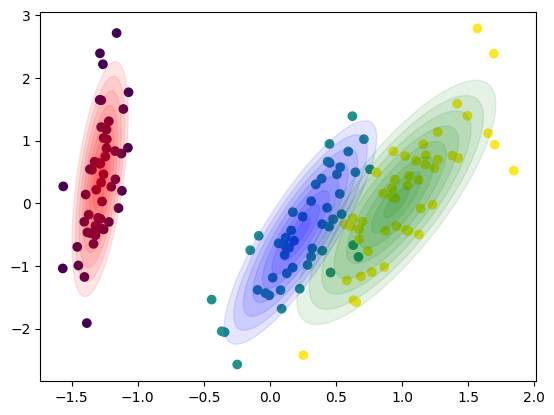

In [7]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from gmr import GMM, plot_error_ellipses


X, y = load_iris(return_X_y=True)
X_pca = PCA(n_components=2, whiten=True, random_state=0).fit_transform(X)

gmm = GMM(n_components=3, random_state=1)
gmm.from_samples(X_pca)

plt.figure()
ax = plt.subplot(111)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plot_error_ellipses(ax, gmm, alpha=0.1, colors=["r", "g", "b"]);

### Clustering Iris with initialization of the GMM from sklearn



We will cluster the Iris dataset but we will use sklearn to initialize our GMM. sklearn allows restricted covariances such as diagonal covariances. This is just for demonstration purposes and does not represent an example of a particularly good fit. Take a look at for a fit with full covariances.



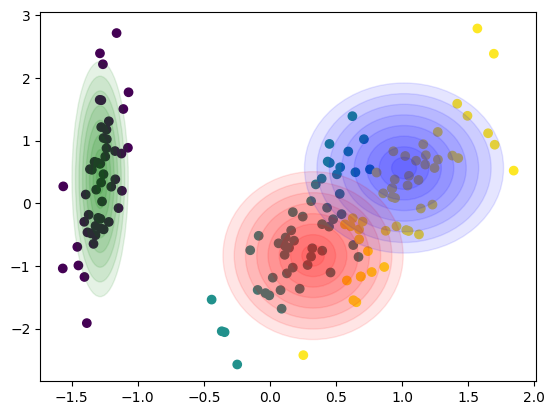

In [8]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from gmr import GMM, plot_error_ellipses


X, y = load_iris(return_X_y=True)
X_pca = PCA(n_components=2, whiten=True, random_state=1).fit_transform(X)

gmm_sklearn = GaussianMixture(n_components=3, covariance_type="diag",
                              random_state=3)
gmm_sklearn.fit(X_pca)
gmm = GMM(
    n_components=3, priors=gmm_sklearn.weights_, means=gmm_sklearn.means_,
    covariances=np.array([np.diag(c) for c in gmm_sklearn.covariances_]))

plt.figure()
ax = plt.subplot(111)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plot_error_ellipses(ax, gmm, alpha=0.1, colors=["r", "g", "b"]);

### Generate Time-Invariant Trajectories with GMR



An additional package is required to load an SVG file: `svgpathtools`. We will further use the Bayesian GMM from sklearn to get a better fit of the data.

We will load an SVG that contains one path that will be used to generate our training data. We extract a sequence of 2D points from the path. We will then compute the differences between points and assume they are velocities between those points. We fit a GMM on samples that contain four features: x- and y-coordinate of the position and the corresponding velocity. We now have a time-invariant representation of a trajectory. Starting from some position (x, y) we can compute a conditional GMM over the velocities. We can sample from the conditional GMM to generate a velocity, integrate the velocity to obtain a new position, and repeat this procedure as long as we want.

Note that we use a "safe" sampling procedure here: we neglect Gaussians that have low prior probability and we resample from a selected Gaussian until we have a velocity that lies within the 70 % confidence interval of the Gaussian. We do this to avoid divergence from the training data.



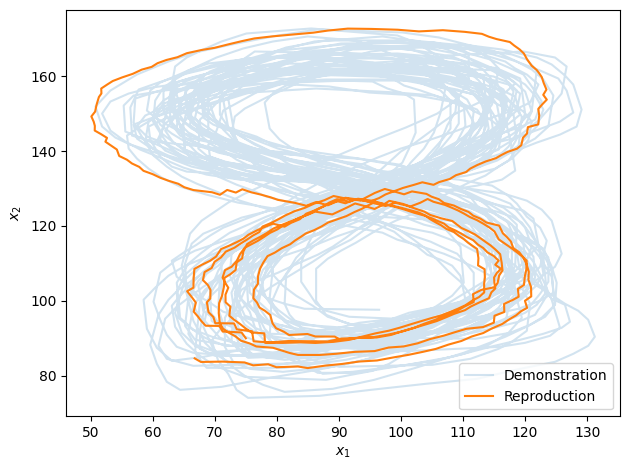

In [9]:
from svgpathtools import svg2paths  # pip install svgpathtools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from gmr import GMM

import requests

url = 'https://raw.githubusercontent.com/AlexanderFabisch/gmr/refs/heads/master/examples/8_plain.svg'
with open('8_plain.svg', 'wb') as f:
    f.write(requests.get(url).content)

paths = svg2paths("8_plain.svg")[0]  # only works if started from gmr's root directory
assert len(paths) == 1
path = paths[0]

points = []
for cb in path:
    for t in np.arange(0, 1, 0.2):
        p = cb.point(t)
        p = [p.real, p.imag]
        points.append(p)
points = np.array(points)

dt = 1.0

X = points[::50]
X_dot = (X[2:] - X[:-2]) / dt
X = X[1:-1]
X_train = np.hstack((X, X_dot))

random_state = np.random.RandomState(0)
n_components = 15

bgmm = BayesianGaussianMixture(
    n_components=n_components, max_iter=500,
    random_state=random_state).fit(X_train)
gmm = GMM(n_components=n_components, priors=bgmm.weights_, means=bgmm.means_,
          covariances=bgmm.covariances_, random_state=random_state)


sampled_path = []
x = np.array([75.0, 90.0])  # left bottom
sampling_dt = 0.2  # increases sampling frequency
for t in range(500):
    sampled_path.append(x)
    cgmm = gmm.condition([0, 1], x)
    # default alpha defines the confidence region (e.g., 0.7 -> 70 %)
    x_dot = cgmm.sample_confidence_region(1, alpha=0.7)[0]
    x = x + sampling_dt * x_dot
sampled_path = np.array(sampled_path)

plt.plot(X[:, 0], X[:, 1], alpha=0.2, label="Demonstration")
plt.plot(sampled_path[:, 0], sampled_path[:, 1], label="Reproduction")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.tight_layout();

### Learn Time-Indexed Trajectories



We learn a GMM from multiple similar trajectories that consist of points (t, x\_1, x\_2), where t is a time variable and x\_1 and x\_2 are 2D coordinates. The GMM is initialized from a Bayesian GMM of sklearn to get a better fit of the data, which is otherwise difficult in this case, where we have discrete steps in the time dimension and x\_1.

We compare the 95 % confidence interval in x\_2 between the original data and the learned GMM.



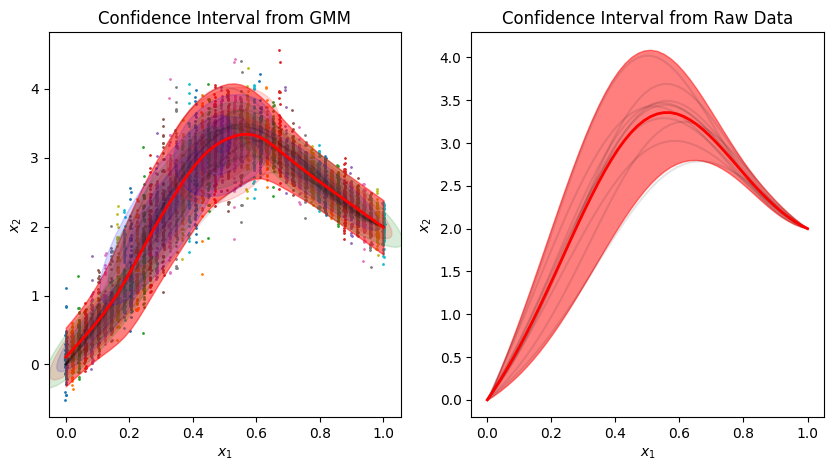

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import BayesianGaussianMixture
from itertools import cycle
from gmr import GMM, kmeansplusplus_initialization, covariance_initialization
from gmr.utils import check_random_state


def make_demonstrations(n_demonstrations, n_steps, sigma=0.25, mu=0.5,
                        start=np.zeros(2), goal=np.ones(2), random_state=None):
    """Generates demonstration that can be used to test imitation learning.

    Parameters
    ----------
    n_demonstrations : int
        Number of noisy demonstrations

    n_steps : int
        Number of time steps

    sigma : float, optional (default: 0.25)
        Standard deviation of noisy component

    mu : float, optional (default: 0.5)
        Mean of noisy component

    start : array, shape (2,), optional (default: 0s)
        Initial position

    goal : array, shape (2,), optional (default: 1s)
        Final position

    random_state : int
        Seed for random number generator

    Returns
    -------
    X : array, shape (n_task_dims, n_steps, n_demonstrations)
        Noisy demonstrated trajectories

    ground_truth : array, shape (n_task_dims, n_steps)
        Original trajectory
    """
    random_state = np.random.RandomState(random_state)

    X = np.empty((2, n_steps, n_demonstrations))

    # Generate ground-truth for plotting
    ground_truth = np.empty((2, n_steps))
    T = np.linspace(-0, 1, n_steps)
    ground_truth[0] = T
    ground_truth[1] = (T / 20 + 1 / (sigma * np.sqrt(2 * np.pi)) *
                       np.exp(-0.5 * ((T - mu) / sigma) ** 2))

    # Generate trajectories
    for i in range(n_demonstrations):
        noisy_sigma = sigma * random_state.normal(1.0, 0.1)
        noisy_mu = mu * random_state.normal(1.0, 0.1)
        X[0, :, i] = T
        X[1, :, i] = T + (1 / (noisy_sigma * np.sqrt(2 * np.pi)) *
                          np.exp(-0.5 * ((T - noisy_mu) /
                                         noisy_sigma) ** 2))

    # Spatial alignment
    current_start = ground_truth[:, 0]
    current_goal = ground_truth[:, -1]
    current_amplitude = current_goal - current_start
    amplitude = goal - start
    ground_truth = ((ground_truth.T - current_start) * amplitude /
                    current_amplitude + start).T

    for demo_idx in range(n_demonstrations):
        current_start = X[:, 0, demo_idx]
        current_goal = X[:, -1, demo_idx]
        current_amplitude = current_goal - current_start
        X[:, :, demo_idx] = ((X[:, :, demo_idx].T - current_start) *
                             amplitude / current_amplitude + start).T

    return X, ground_truth


plot_covariances = True
X, _ = make_demonstrations(
    n_demonstrations=10, n_steps=50, goal=np.array([1., 2.]),
    random_state=0)
X = X.transpose(2, 1, 0)
steps = X[:, :, 0].mean(axis=0)
expected_mean = X[:, :, 1].mean(axis=0)
expected_std = X[:, :, 1].std(axis=0)

n_demonstrations, n_steps, n_task_dims = X.shape
X_train = np.empty((n_demonstrations, n_steps, n_task_dims + 1))
X_train[:, :, 1:] = X
t = np.linspace(0, 1, n_steps)
X_train[:, :, 0] = t
X_train = X_train.reshape(n_demonstrations * n_steps, n_task_dims + 1)

random_state = check_random_state(0)
n_components = 4
initial_means = kmeansplusplus_initialization(X_train, n_components, random_state)
initial_covs = covariance_initialization(X_train, n_components)
bgmm = BayesianGaussianMixture(n_components=n_components, max_iter=100).fit(X_train)
gmm = GMM(
    n_components=n_components,
    priors=bgmm.weights_,
    means=bgmm.means_,
    covariances=bgmm.covariances_,
    random_state=random_state)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Confidence Interval from GMM")

plt.plot(X[:, :, 0].T, X[:, :, 1].T, c="k", alpha=0.1)

means_over_time = []
y_stds = []
for step in t:
    conditional_gmm = gmm.condition([0], np.array([step]))
    conditional_mvn = conditional_gmm.to_mvn()
    means_over_time.append(conditional_mvn.mean)
    y_stds.append(np.sqrt(conditional_mvn.covariance[1, 1]))
    samples = conditional_gmm.sample(100)
    plt.scatter(samples[:, 0], samples[:, 1], s=1)
means_over_time = np.array(means_over_time)
y_stds = np.array(y_stds)

plt.plot(means_over_time[:, 0], means_over_time[:, 1], c="r", lw=2)
plt.fill_between(
    means_over_time[:, 0],
    means_over_time[:, 1] - 1.96 * y_stds,
    means_over_time[:, 1] + 1.96 * y_stds,
    color="r", alpha=0.5)

if plot_covariances:
    colors = cycle(["r", "g", "b"])
    for factor in np.linspace(0.5, 4.0, 8):
        new_gmm = GMM(
            n_components=len(gmm.means), priors=gmm.priors,
            means=gmm.means[:, 1:], covariances=gmm.covariances[:, 1:, 1:],
            random_state=gmm.random_state)
        for mean, (angle, width, height) in new_gmm.to_ellipses(factor):
            ell = Ellipse(xy=mean, width=width, height=height,
                            angle=np.degrees(angle))
            ell.set_alpha(0.15)
            ell.set_color(next(colors))
            plt.gca().add_artist(ell)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.subplot(122)
plt.title("Confidence Interval from Raw Data")
plt.plot(X[:, :, 0].T, X[:, :, 1].T, c="k", alpha=0.1)

plt.plot(steps, expected_mean, c="r", lw=2)
plt.fill_between(
    steps,
    expected_mean - 1.96 * expected_std,
    expected_mean + 1.96 * expected_std,
    color="r", alpha=0.5)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$");

### Estimate Multivariate Normal Distribution from Samples



The maximum likelihood estimate (MLE) of an MVN can be computed directly. Then we can sample from the estimated distribution or compute the marginal distributions.



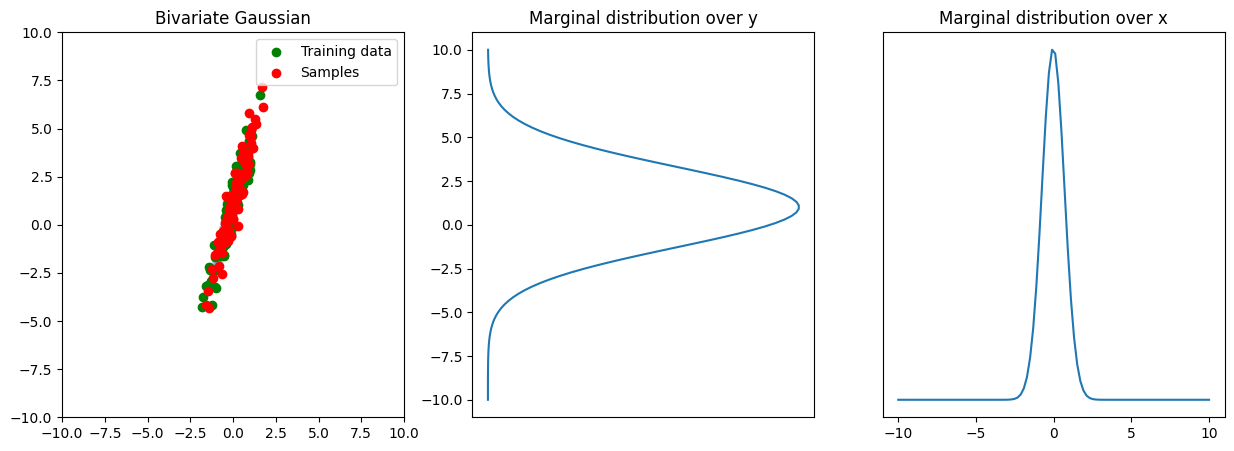

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, plot_error_ellipse


random_state = check_random_state(0)
mvn = MVN(random_state=random_state)
X = random_state.multivariate_normal([0.0, 1.0], [[0.5, 1.5], [1.5, 5.0]],
                                     size=(100,))
mvn.from_samples(X)
X_sampled = mvn.sample(n_samples=100)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plot_error_ellipse(plt.gca(), mvn)
plt.scatter(X[:, 0], X[:, 1], c="g", label="Training data")
plt.scatter(X_sampled[:, 0], X_sampled[:, 1], c="r", label="Samples")
plt.title("Bivariate Gaussian")
plt.legend(loc="best")

x = np.linspace(-10, 10, 100)
plt.subplot(1, 3, 2)
plt.xticks(())
marginalized = mvn.marginalize(np.array([1]))
plt.plot(marginalized.to_probability_density(x[:, np.newaxis]), x)
plt.title("Marginal distribution over y")

plt.subplot(1, 3, 3)
plt.yticks(())
marginalized = mvn.marginalize(np.array([0]))
plt.plot(x, marginalized.to_probability_density(x[:, np.newaxis]))
plt.title("Marginal distribution over x");

### Estimate Gaussian Mixture Model from Samples



The maximum likelihood estimate (MLE) of a GMM cannot be computed directly. Instead, we have to use expectation-maximization (EM). Then we can sample from the estimated distribution or compute conditional distributions.



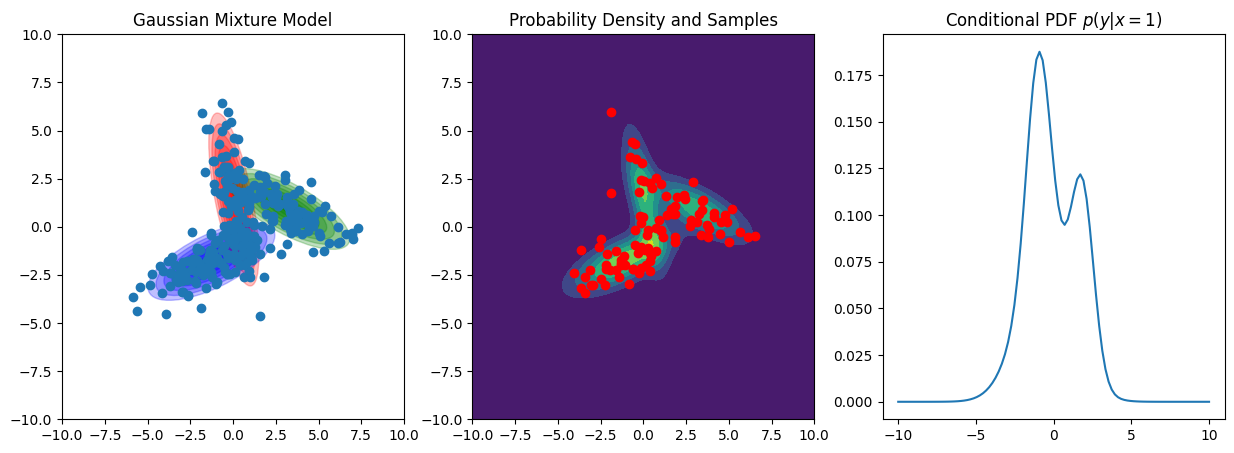

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = 300
n_features = 2
X = np.ndarray((n_samples, n_features))
X[:n_samples // 3, :] = random_state.multivariate_normal(
    [0.0, 1.0], [[0.5, -1.0], [-1.0, 5.0]], size=(n_samples // 3,))
X[n_samples // 3:-n_samples // 3, :] = random_state.multivariate_normal(
    [-2.0, -2.0], [[3.0, 1.0], [1.0, 1.0]], size=(n_samples // 3,))
X[-n_samples // 3:, :] = random_state.multivariate_normal(
    [3.0, 1.0], [[3.0, -1.0], [-1.0, 1.0]], size=(n_samples // 3,))

gmm = GMM(n_components=3, random_state=random_state)
gmm.from_samples(X)
cond = gmm.condition(np.array([0]), np.array([1.0]))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Gaussian Mixture Model")
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b"])
plt.scatter(X[:, 0], X[:, 1])

plt.subplot(1, 3, 2)
plt.title("Probability Density and Samples")
plt.xlim((-10, 10))
plt.ylim((-10, 10))
x, y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
X_test = np.vstack((x.ravel(), y.ravel())).T
p = gmm.to_probability_density(X_test)
p = p.reshape(*x.shape)
plt.contourf(x, y, p)
X_sampled = gmm.sample(100)
plt.scatter(X_sampled[:, 0], X_sampled[:, 1], c="r")

plt.subplot(1, 3, 3)
plt.title("Conditional PDF $p(y | x = 1)$")
X_test = np.linspace(-10, 10, 100)
plt.plot(X_test, cond.to_probability_density(X_test[:, np.newaxis]));

### Compare Initializations Strategies



Expectation Maximization for Gaussian Mixture Models does not have a unique solution. The result depends on the initialization. It is particularly important to either normalize the training data or set the covariances accordingly. In addition, k-means++ initialization helps to find a good initial distribution of means.

Here is a numerically challenging example in which we find a better distribution of individual Gaussians with k-means++.



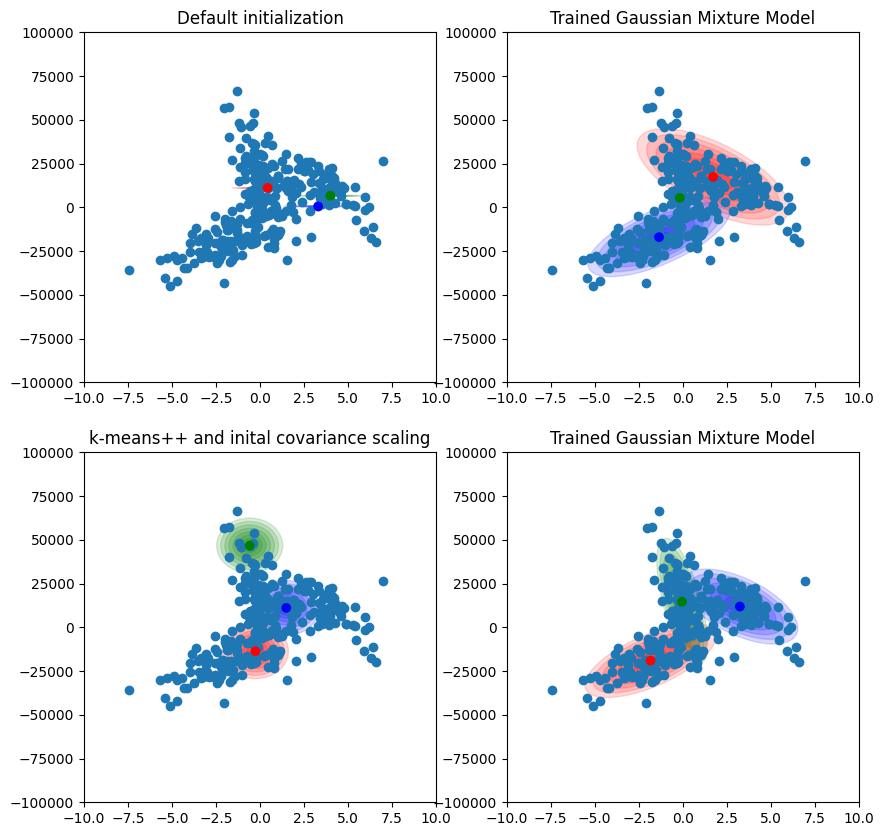

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import GMM, plot_error_ellipses, kmeansplusplus_initialization, covariance_initialization


random_state = check_random_state(1)

n_samples = 300
n_features = 2
X = np.ndarray((n_samples, n_features))
X[:n_samples // 3, :] = random_state.multivariate_normal(
    [0.0, 1.0], [[0.5, -1.0], [-1.0, 5.0]], size=(n_samples // 3,))
X[n_samples // 3:-n_samples // 3, :] = random_state.multivariate_normal(
    [-2.0, -2.0], [[3.0, 1.0], [1.0, 1.0]], size=(n_samples // 3,))
X[-n_samples // 3:, :] = random_state.multivariate_normal(
    [3.0, 1.0], [[3.0, -1.0], [-1.0, 1.0]], size=(n_samples // 3,))

# artificial scaling, makes standard implementation fail
# either the initial covariances have to be adjusted or we have
# to normalize the dataset
X[:, 1] *= 10000.0

plt.figure(figsize=(10, 10))

n_components = 3
initial_covs = np.empty((n_components, n_features, n_features))
initial_covs[:] = np.eye(n_features)
gmm = GMM(n_components=n_components, random_state=random_state)
gmm.from_samples(X, init_params="random", n_iter=0)

plt.subplot(2, 2, 1)
plt.title("Default initialization")
plt.xlim((-10, 10))
plt.ylim((-100000, 100000))
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b"], alpha=0.15)
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], color=["r", "g", "b"])

gmm.from_samples(X)

plt.subplot(2, 2, 2)
plt.title("Trained Gaussian Mixture Model")
plt.xlim((-10, 10))
plt.ylim((-100000, 100000))
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b"], alpha=0.15)
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], color=["r", "g", "b"])

initial_means = kmeansplusplus_initialization(X, n_components, random_state)
initial_covs = covariance_initialization(X, n_components)
gmm = GMM(n_components=n_components, random_state=random_state)
gmm.from_samples(X, init_params="kmeans++", n_iter=0)

plt.subplot(2, 2, 3)
plt.title("k-means++ and inital covariance scaling")
plt.xlim((-10, 10))
plt.ylim((-100000, 100000))
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b"], alpha=0.15)
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], color=["r", "g", "b"])

gmm.from_samples(X)

plt.subplot(2, 2, 4)
plt.title("Trained Gaussian Mixture Model")
plt.xlim((-10, 10))
plt.ylim((-100000, 100000))
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b"], alpha=0.15)
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], color=["r", "g", "b"]);

### Unscented Transform



The [unscented transform](https://en.wikipedia.org/wiki/Unscented_transform) can be used to to transform a Gaussian distribution through a nonlinear
function.

In this example we transform an MVN from 2D Cartesian coordinates (1) to polar coordinates (2) and back to Cartesian coordinates (3). It does not work perfectly because the transformations are highly nonlinear.



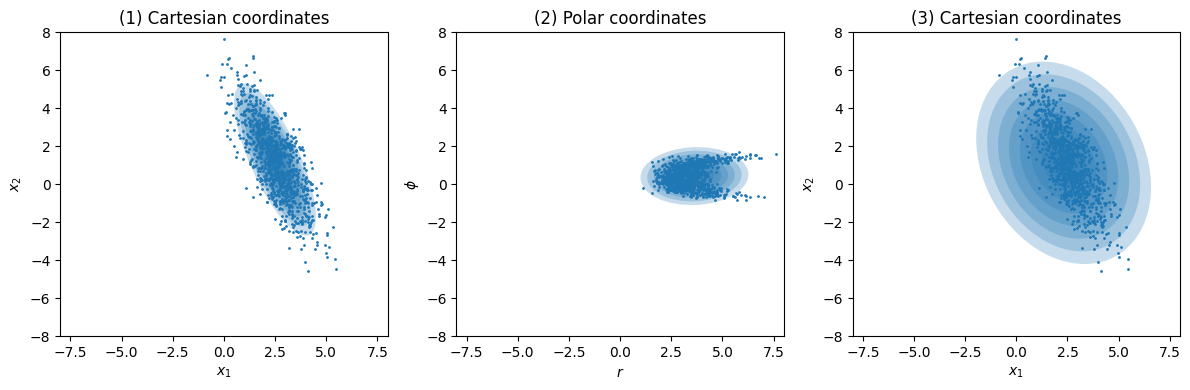

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from gmr import MVN, plot_error_ellipse


def cartesian_to_polar(X):
    Y = np.empty_like(X)
    Y[:, 0] = np.sqrt(X[:, 0] ** 2 + X[:, 1] ** 2)
    Y[:, 1] = np.arctan2(X[:, 1], X[:, 0])
    return Y


def polar_to_cartesian(Y):
    X = np.empty_like(Y)
    X[:, 0] = Y[:, 0] * np.cos(Y[:, 1])
    X[:, 1] = Y[:, 0] * np.sin(Y[:, 1])
    return X


plt.figure(figsize=(12, 4))

# parameters of unscented transform, these are the defaults:
alpha = 1e-3
beta = 2.0  # lower values give better estimates
kappa = 0.0

ax = plt.subplot(131)
ax.set_title("(1) Cartesian coordinates")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_xlim((-8, 8))
ax.set_ylim((-8, 8))
mvn_cartesian = MVN(
    mean=np.array([2.5, 1.3]),
    covariance=np.array([[1.0, -1.5], [-1.5, 4.0]]),
    random_state=0)
plot_error_ellipse(ax, mvn_cartesian)
samples_cartesian = mvn_cartesian.sample(1000)
ax.scatter(samples_cartesian[:, 0], samples_cartesian[:, 1], s=1)

ax = plt.subplot(132)
ax.set_title("(2) Polar coordinates")
ax.set_xlabel("$r$")
ax.set_ylabel(r"$\phi$")
ax.set_xlim((-8, 8))
ax.set_ylim((-8, 8))
sigma_points_cartesian = mvn_cartesian.sigma_points(alpha=alpha, kappa=kappa)
sigma_points_polar = cartesian_to_polar(sigma_points_cartesian)
mvn_polar = mvn_cartesian.estimate_from_sigma_points(sigma_points_polar, alpha=alpha, beta=beta, kappa=kappa)
plot_error_ellipse(ax, mvn_polar)
samples_polar = cartesian_to_polar(samples_cartesian)
ax.scatter(samples_polar[:, 0], samples_polar[:, 1], s=1)

ax = plt.subplot(133)
ax.set_title("(3) Cartesian coordinates")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_xlim((-8, 8))
ax.set_ylim((-8, 8))
sigma_points_polar2 = mvn_polar.sigma_points(alpha=alpha, kappa=kappa)
sigma_points_cartesian2 = polar_to_cartesian(sigma_points_polar2)
mvn_cartesian2 = mvn_polar.estimate_from_sigma_points(sigma_points_cartesian2, alpha=alpha, beta=beta, kappa=kappa)
plot_error_ellipse(ax, mvn_cartesian2)
samples_cartesian2 = polar_to_cartesian(samples_polar)
ax.scatter(samples_cartesian2[:, 0], samples_cartesian2[:, 1], s=1)

plt.tight_layout();